In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/dongmin/2303-blues_machine


In [2]:
import torch
import numpy as np

import muspy
import pypianoroll as pypi

from model import Encoder, Decoder, Seq2Seq
from dataset import BluesPairSet
from utils import prepare_inference_res, prepare_inference_midi, model_output_to_pianoroll, prepare_compare_res, pianoroll2muspy, midi2audio

from pathlib import Path
import IPython.display as ipd

In [3]:
dataset = BluesPairSet()

100%|██████████| 104/104 [00:07<00:00, 13.34it/s]


In [4]:
DEVICE = 'cuda'
EMB_LEN = dataset.vocab_size
EMB_DIM = 64
HID_DIM = 256
NUM_LAYER = 3

encoder = Encoder(EMB_LEN, EMB_DIM, HID_DIM, num_layers=NUM_LAYER, device=DEVICE) # input size(embed len), embed size, hidden size
decoder = Decoder(EMB_LEN, EMB_DIM, HID_DIM, num_layers=NUM_LAYER, device=DEVICE) # output size(embed len), embed size, hidden size

model = Seq2Seq(encoder, decoder, device=DEVICE)

In [5]:
def test_model(model, call, res, max_len=256):
    model.eval()

    with torch.inference_mode():
        output = model(call, res, inference_mode=True, max_len=max_len) # (max len, vocab size)
        
        output = output.argmax(1)
            
        return output

In [6]:
call_filename = 'texas_blues_shuffle-4|4-D-120-001-2-c.mid'
res_filename = 'texas_blues_shuffle-4|4-D-120-001-2-r.mid'

call_path = Path(f'data_test/{call_filename}')
res_path = Path(f'data_test/{res_filename}')

In [13]:
model_tags = [
    '1691559134-9000', # 0
    '1691559151-9000', # 1
    
]
model_name = 'blues_call_and_res_model-'

model_tag = model_tags[1]

loaded_states = torch.load(f'models/{model_name}{model_tag}.pt')['model']

model.load_state_dict(loaded_states)

<All keys matched successfully>

In [14]:
original_pianorolls, call = prepare_inference_midi(call_path, dataset.token2idx)
res = prepare_inference_res(dataset.token2idx)

call = call.to(DEVICE)
res = res.to(DEVICE)

output = test_model(model, call, res, max_len=32)

output_as_token = [ dataset.idx2token[idx] for idx in output.tolist() ]

last_index = None
for idx, token in enumerate(output_as_token):
    if token == '<end>':
        last_index = idx
        break
    
output_slice = output[:last_index]

[<Axes: xlabel='time (beat)', ylabel='\n\npitch'>]

[<Axes: xlabel='time (beat)', ylabel='None\n\npitch'>]

[<Axes: xlabel='time (beat)', ylabel='None\n\npitch'>]

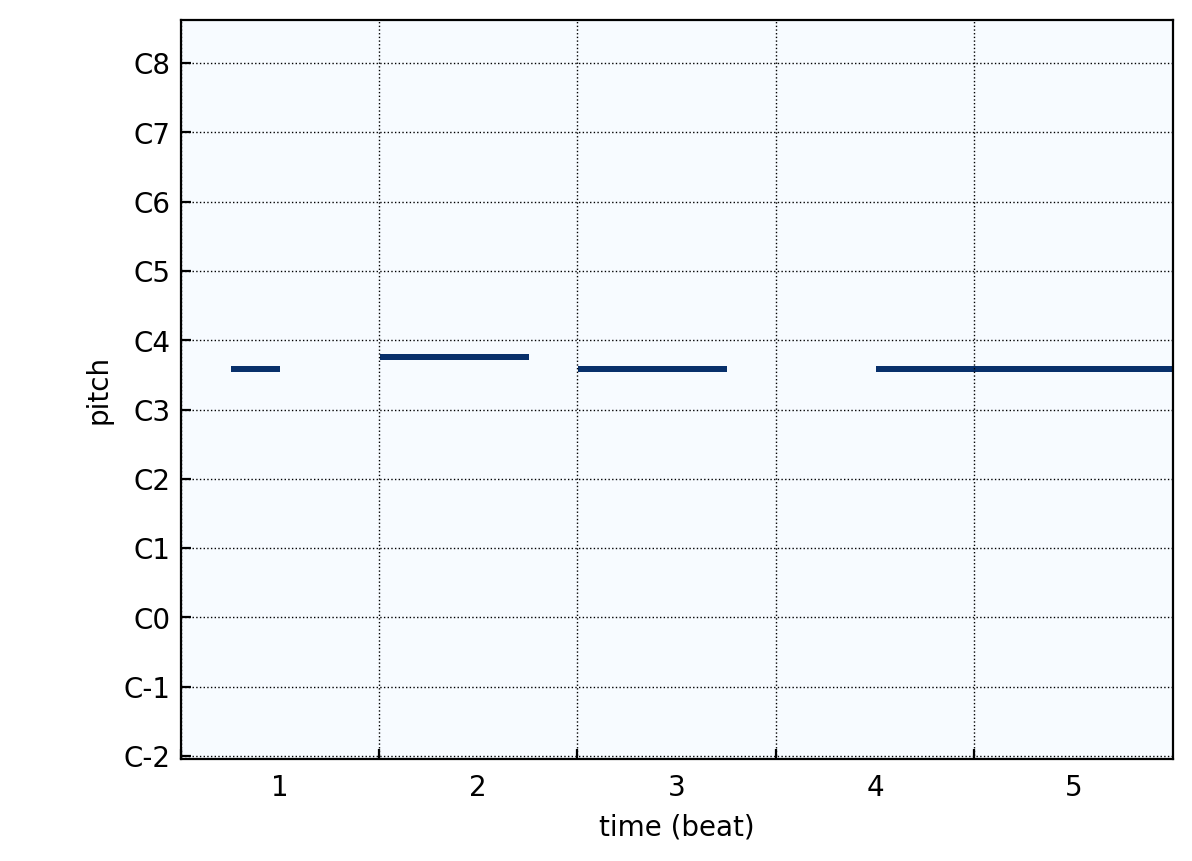

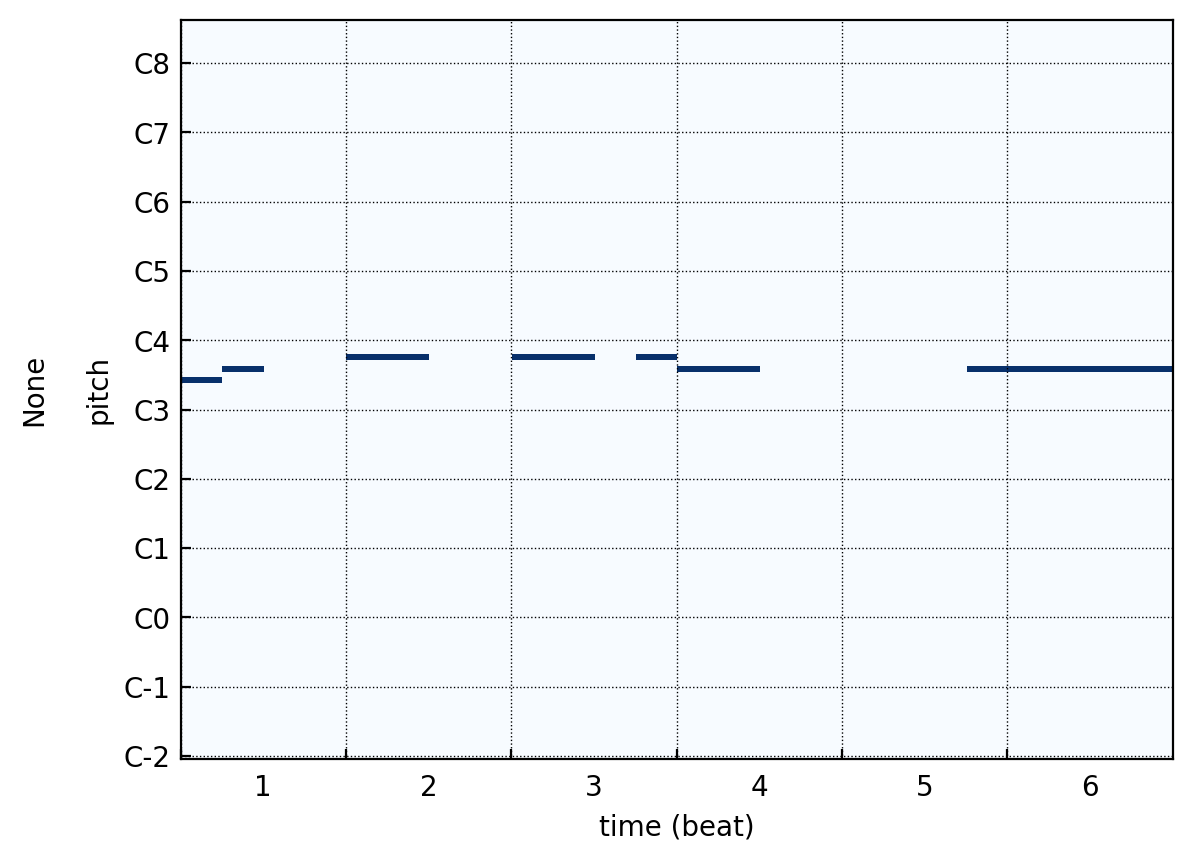

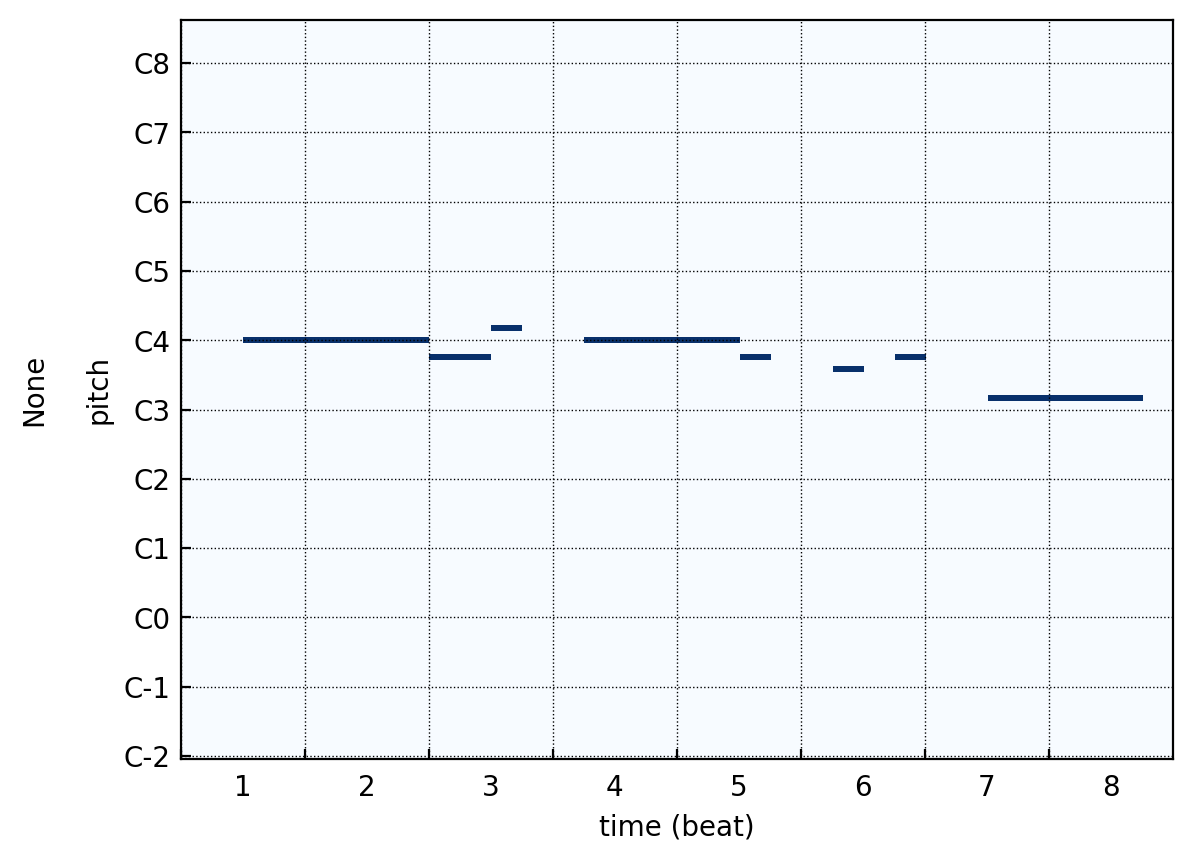

In [15]:
call_quant_pianoroll_obj = original_pianorolls[1]
ipd.display(call_quant_pianoroll_obj.plot())

original_res = prepare_compare_res(res_path, dataset.token2idx, dataset.idx2token)
ipd.display(original_res.plot())

output_obj = model_output_to_pianoroll(output_slice, dataset.idx2token, original_res)
ipd.display(output_obj.plot())

In [16]:
original_call_filename = f'{call_filename.split(".")[0]}-original.mid'
original_res_filename = f'{res_filename.split(".")[0]}-original.mid'
output_filename = f'{res_filename.split(".")[0]}-infered.mid'

original_res_song = pianoroll2muspy(original_res)
muspy.write_midi(f'test_result/{original_res_filename}', original_res_song)

output_song = pianoroll2muspy(output_obj)
muspy.write_midi(f'test_result/{output_filename}', output_song)

original_call_song = pianoroll2muspy(original_pianorolls[0])
muspy.write_midi(f'test_result/{original_call_filename}', original_call_song)


In [17]:
result_dir_path = 'test_result/'
result_midi_paths = sorted(list(Path(result_dir_path).rglob('*.mid')))

for path in result_midi_paths:
    filename = path.name.split('.')[0]
    midi2audio(str(path), f'{result_dir_path}{filename}.wav')

FluidSynth runtime version 2.1.1
Copyright (C) 2000-2020 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Rendering audio to file 'test_result/texas_blues_shuffle-4|4-D-120-001-2-c-original.wav'..
FluidSynth runtime version 2.1.1
Copyright (C) 2000-2020 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Rendering audio to file 'test_result/texas_blues_shuffle-4|4-D-120-001-2-r-infered.wav'..
FluidSynth runtime version 2.1.1
Copyright (C) 2000-2020 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Rendering audio to file 'test_result/texas_blues_shuffle-4|4-D-120-001-2-r-original.wav'..


In [18]:
result_wav_paths = sorted(list(Path(result_dir_path).rglob('*.wav')))

for path in result_wav_paths:
    print(path.name.split('.')[0].split('-')[-2:])
    ipd.display(ipd.Audio(path))

['c', 'original']


['r', 'infered']


['r', 'original']
